In [1]:
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt
from pytorch_forecasting import TemporalFusionTransformer, RecurrentNetwork
import pandas as pd

sys.path.append("../src")
# from gcn import KubernetesA3TGCN, create_dataset
from a3tgcn import KubernetesA3TGCN, create_dataset
from recurrent import get_dataset

## A3TGCN

In [2]:
a3tgcn = KubernetesA3TGCN(12, 84, 1)
a3tgcn.load_state_dict(torch.load("../models/ram/a3tgcn.pt"))

a3tgcn.to("cpu")
print(sum(p.numel() for p in a3tgcn.parameters()), "parameters")

45950 parameters


In [3]:
node_features = np.load("../data/test/node_features.npz")
edge_features = np.load("../data/test/edge_features.npz")

X, y = node_features["X"], node_features["y"]
A = edge_features["A"]

k8s_dataset = create_dataset(X, A, y, 1)

In [4]:
y_a3tgcn = []
p_a3tgcn = []
for (x, edge_index, edge_attr, y) in k8s_dataset:
    y_a3tgcn.append(y[1].numpy())
    p_a3tgcn.append(
        a3tgcn(x[1].unsqueeze(2), edge_index[1], edge_attr[1]).detach().numpy().ravel()
    )
y_a3tgcn = np.vstack(y_a3tgcn)
p_a3tgcn = np.vstack(p_a3tgcn)

In [5]:
print("A3TGCN mse:", np.mean((y_a3tgcn - p_a3tgcn) ** 2))
print("A3TGCN mape:", np.mean(np.abs((y_a3tgcn - p_a3tgcn) / y_a3tgcn)))

A3TGCN mse: 4.4293118
A3TGCN mape: 1.1559137


In [6]:
print("MSE by pod:", np.mean((y_a3tgcn - p_a3tgcn) ** 2, axis=0))
print("MAPE by pod:", np.mean(np.abs((y_a3tgcn - p_a3tgcn) / y_a3tgcn), axis=0))

MSE by pod: [2.255899  7.7950277 7.276541  5.9062805 2.5215688 3.6562023 4.923829
 2.481134  5.049168  1.0276544 5.829133 ]
MAPE by pod: [1.3257519  1.2003747  0.99923396 1.0597607  1.4354779  1.1817043
 0.9876849  1.2757847  1.0669396  1.0378157  1.1445229 ]


## Temporal-Fusion Transformer

In [7]:
tft = TemporalFusionTransformer.load_from_checkpoint("../models/ram/tft.ckpt")
tft.eval()
print(sum(p.numel() for p in tft.parameters()), "parameters")

6629482 parameters


In [8]:
recurrent_dataset, _ = get_dataset("../data/test", 1, 12)
dataloader = recurrent_dataset.to_dataloader(train=False, batch_size=1)

In [9]:
tft_predictions = tft.predict(dataloader, return_y=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [10]:
p_tft = torch.cat(tft_predictions.output, axis=1).swapaxes(0, 1).cpu().detach().numpy()
y_tft = torch.cat(tft_predictions.y[0]).cpu().detach().numpy()

In [11]:
print("TFT mse:", np.mean((y_tft - p_tft) ** 2))
print("TFT mape:", np.mean(np.abs((y_tft - p_tft) / y_tft)))

TFT mse: 3.2551556
TFT mape: 3.55622


In [12]:
print("MSE by pod:", np.mean((y_tft - p_tft) ** 2, axis=1))
print("MAPE by pod:", np.mean(np.abs((y_tft - p_tft) / y_tft), axis=1))

MSE by pod: [1.2944506 9.562062  4.1722217 5.998811  1.745766  1.557421  2.4799533
 1.1689851 2.5956771 1.4322867 3.799073 ]
MAPE by pod: [3.058032  6.516496  3.4384096 1.3671542 5.897688  6.342593  1.4737362
 2.7865577 1.774995  2.7433338 3.719424 ]


## RNN

In [13]:
rnn = RecurrentNetwork.load_from_checkpoint("../models/ram/rnn.ckpt")
rnn.eval()
print(sum(p.numel() for p in rnn.parameters()), "parameters")

5373155 parameters


In [14]:
rnn_predictions = rnn.predict(dataloader, return_y=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [15]:
p_rnn = torch.cat(rnn_predictions.output, axis=1).swapaxes(0, 1).cpu().detach().numpy()
y_rnn = torch.cat(rnn_predictions.y[0]).cpu().detach().numpy()

In [16]:
print("RNN mse:", np.mean((y_rnn - p_rnn) ** 2))
print("RNN mape:", np.mean(np.abs((y_rnn - p_rnn) / y_rnn)))

RNN mse: 0.5596967
RNN mape: 1.8112916


In [17]:
print("MSE by pod:", np.mean((y_rnn - p_rnn) ** 2, axis=1))
print("MAPE by pod:", np.mean(np.abs((y_rnn - p_rnn) / y_rnn), axis=1))

MSE by pod: [0.44730192 0.77309823 0.688434   0.9556882  0.4166959  0.42193654
 0.49918163 0.3029946  0.7384182  0.27032366 0.6425903 ]
MAPE by pod: [2.465669  1.4271789 1.6243366 1.4288629 3.2535224 1.4415882 0.7810327
 2.5416536 1.5475417 1.3920399 2.020782 ]


In [19]:
np.mean((y_rnn - p_rnn) ** 2, axis=1).argmax()

3

## Plots

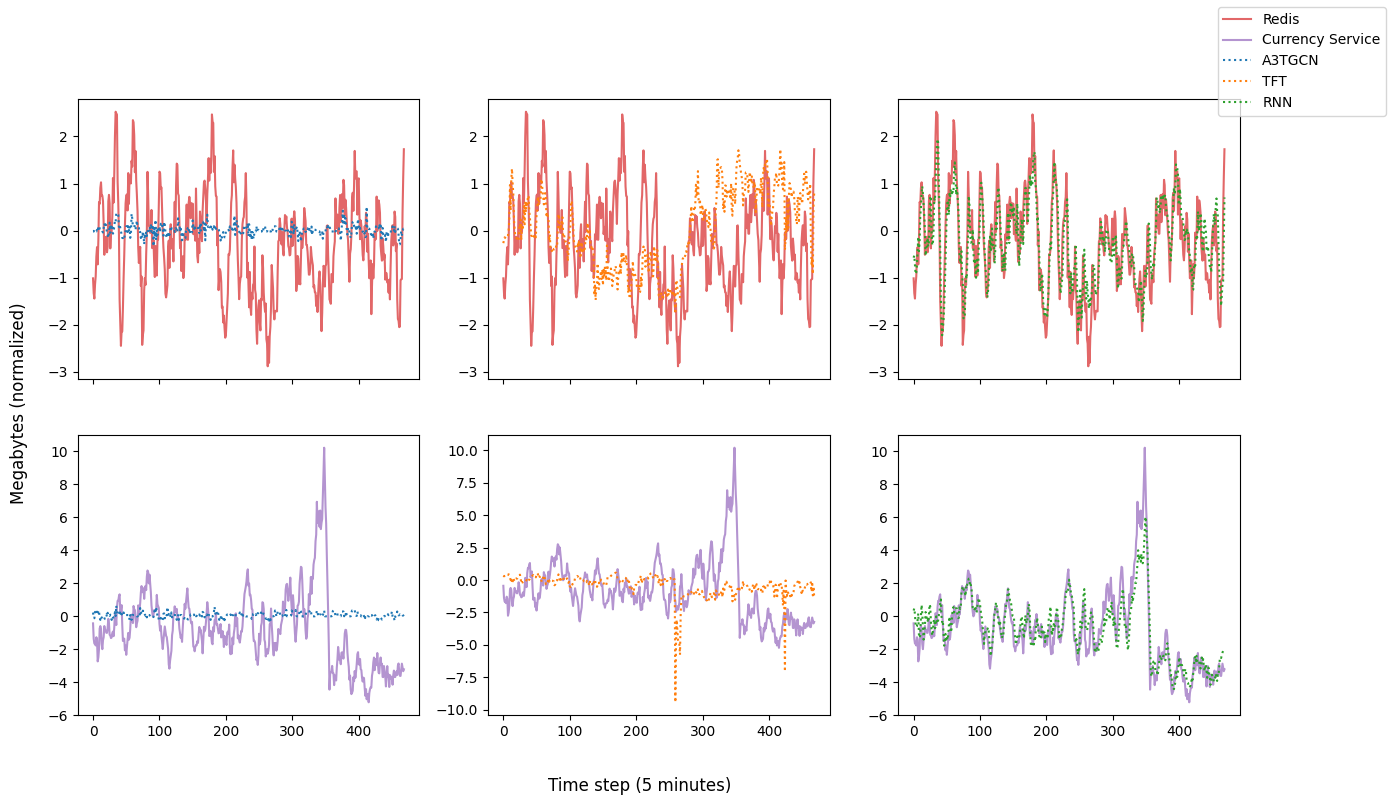

In [21]:
fig, axs = plt.subplots(2, 3, figsize=(15, 8), sharex=True)
color_cycle = plt.rcParams['axes.prop_cycle']()

labels = ["A3TGCN", "TFT", "RNN"]
features_names = ["Redis", "Currency Service"]
model_colors = [next(color_cycle), next(color_cycle), next(color_cycle)]
feature_colors = [next(color_cycle), next(color_cycle)]

for i, feature in enumerate([9, 3]):
    for j, p in enumerate([p_a3tgcn.swapaxes(0, 1), p_tft, p_rnn]):
        axs[i, j].plot(y_a3tgcn[:, feature], label=features_names[i], alpha=0.7, **feature_colors[i])
        axs[i, j].plot(p[feature], label=labels[j], ls="dotted", **model_colors[j])

legend_lines = []
legend_labels = []        
for i in range(2):
    legend_lines.append(axs[i, 0].get_legend_handles_labels()[0][0])
    legend_labels.append(axs[i, 0].get_legend_handles_labels()[1][0])
for j in range(3):
    legend_lines.append(axs[0, j].get_legend_handles_labels()[0][1])
    legend_labels.append(axs[0, j].get_legend_handles_labels()[1][1])

fig.supxlabel("Time step (5 minutes)")
fig.supylabel("Megabytes (normalized)", x=0.08)
fig.legend(legend_lines, legend_labels)
fig.savefig("./img/RAM predictions.png", dpi=300, transparent=True, bbox_inches='tight');